In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from astropy import units as u
from astropy.coordinates import SkyCoord , Angle, get_sun, EarthLocation, AltAz, get_moon
from astropy.coordinates.erfa_astrom import erfa_astrom, ErfaAstromInterpolator
from astropy.time import Time, TimeDelta
from datetime import datetime

# Pasos para elegir targets

### Descargar la última iteración de la lista de TOIs
#### Ordenar de más reciente a más antiguo
### Se solicita información de ephemerides para ver si son observables por FIDEOS??
### Se filtra por magnitud < 12

# 1. Descargar la ultima iteracion de la lista de TOIs

In [2]:
print("Downloading the latest TOI list...")
url="https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=pipe"
TOI_df=pd.read_csv(url, delimiter='|', index_col=1)
print("Download finished!")

print("Number of TOIs:", len(TOI_df))

Download finished!
Number of TOIs: 6119


# 2. Ephemerides

In [3]:
# Creamos un dataframe con PCs y APCs con TESS mag <= 10.
bool_mask = TOI_df['TESS Mag'] <= 10
TOI_dfMag = TOI_df[bool_mask]
bool_mask = TOI_dfMag['TFOPWG Disposition'] == 'PC'
TOI_dfPC = TOI_dfMag[bool_mask]
bool_mask = TOI_dfMag['TFOPWG Disposition'] == 'APC'
TOI_dfAPC = TOI_dfMag[bool_mask]
TOI_df = pd.concat([TOI_dfPC, TOI_dfAPC])
TOI_df['Date TOI Alerted (UTC)'] = pd.to_datetime(TOI_df['Date TOI Alerted (UTC)'])
TOI_df = TOI_df.sort_values(by='Date TOI Alerted (UTC)', ascending=False)

In [4]:
print("Number of TOIs PCs and APCs under TESS mag 10:", len(TOI_df))

Number of TOIs PCs and APCs under TESS mag 10: 677


In [5]:
# we save the original array for masking later
TOI_og = TOI_df

### Tenemos que definir la observing time, dado la posicion del Sol en la Silla y una fecha.

In [6]:
date_input = '2022-11-28'
date = date_input.split('-')

In [7]:
times = Time(datetime(int(date[0]), int(date[1]), int(date[2]), 23, 59, 0))+np.linspace(-6, 9, 901)* u.hour

Ahora se busca el momento donde el sol cruza los -18° de altitud desde la posicion en La Silla

In [8]:
laSilla = EarthLocation.from_geodetic(-70.7375, -29.2575,[2347])
sunPos = get_sun(times)
aaFrame = AltAz(obstime=times, location=laSilla)

In [9]:
aa_sunPos = sunPos.transform_to(aaFrame) 

### Buscamos el tiempo donde el sol llega a los -12° y -18

In [10]:
begin = np.argmax(aa_sunPos.alt.value < -12)
end = np.argmax(np.flip(aa_sunPos.alt).value < -18)

In [11]:
twiBegin = times[begin]
twiEnd = np.flip(times)[end]

In [12]:
print(twiBegin)

2022-11-29 00:25:00


In [13]:
print(twiEnd)

2022-11-29 08:03:00


Ahora que tenemos la hora de inicio y de termino del twilight, tenemos el tiempo para calcular efemerides de luna y targets.

In [14]:
obsTimeDelta = twiEnd + .5*u.hour - (twiBegin - .5*u.hour)
obsTimeDelta = TimeDelta((obsTimeDelta.value * 24 // 1) / 24)
steps = int(np.round(obsTimeDelta.sec,0) / 60)
obsDateTime = twiBegin - .5*u.hour + obsTimeDelta * np.linspace(0, 1, steps+1)

In [15]:
# Marco AltAz de La Silla
aaFrame = AltAz(obstime=obsDateTime, location=laSilla)

In [16]:
# Efemerides Luna
moonPos = get_moon(obsDateTime, laSilla)
aa_moonPos = moonPos.transform_to(aaFrame) 

D:\miniconda3\envs\tfopFideos\lib\site-packages\erfa\core.py:4613: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
D:\miniconda3\envs\tfopFideos\lib\site-packages\erfa\core.py:19005: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
D:\miniconda3\envs\tfopFideos\lib\site-packages\erfa\core.py:4029: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)


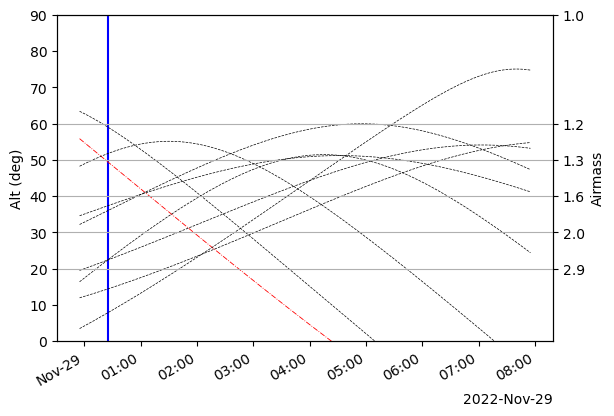

In [17]:
fig, ax = plt.subplots()
# We plot the datetime in a readable format

plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.gca().xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.HourLocator()))

# We plot the astronomical twilight beginning and ending
indexBegin = np.argmax(obsDateTime == twiBegin)
indexEnd = np.argmax(obsDateTime == twiEnd)
plt.axvline(obsDateTime[indexBegin].value, color = 'b')
if indexEnd != 0:
    plt.axvline(obsDateTime[indexEnd].value, color = 'b')
# We plot the moon Alt
ax.plot(obsDateTime.plot_date, aa_moonPos.alt, ls='-.', color="red", lw=.6)
ax.set_ylabel('Alt (deg)')
ax.set_ylim([0,90])
#plot targets
aa_targetIndex = np.array([])
x = 0
while x < 150:
    targetPos = SkyCoord(ra=TOI_df['RA'].iloc[x], dec=TOI_df['Dec'].iloc[x], 
                         distance=TOI_df['Stellar Distance (pc)'].iloc[x] ,
                         unit=(u.hourangle, u.deg, u.pc), obstime=obsDateTime)
    with erfa_astrom.set(ErfaAstromInterpolator(int(steps/60) * u.hour)): 
        temp = targetPos.transform_to(aaFrame)
        if np.array([temp.alt.value>=50]).sum() >= 60:
            aa_targetIndex = np.append(aa_targetIndex, x)
            ax.plot(obsDateTime.plot_date, temp.alt, ls='--', color="black", lw=.5)
    x += 1 
# Airmass axis
altitude_ticks = np.array([20, 30, 40, 50, 60, 90])
airmass_ticks = np.round(1./np.cos(np.radians(90 - altitude_ticks)),1)
ax2 = ax.twinx()
ax2.set_yticks(altitude_ticks)
ax2.set_yticklabels(airmass_ticks)
ax2.set_ylim(ax.get_ylim())
ax2.set_ylabel('Airmass')
ax2.grid()
#
plt.gcf().autofmt_xdate()
plt.show()

In [145]:
observable_df = pd.DataFrame(columns=TOI_og.columns)
x = 0
while x < len(aa_targetIndex):
    index = int(aa_targetIndex[x])
    observable_df = pd.concat([observable_df, TOI_og.iloc[index:index+1]])
    x += 1

In [20]:
header = ['TIC ID', 'RA', 'Dec']
observable_df.to_csv(date_input+'.csv', columns = header, sep =' ', index=False)
observable_df.to_csv(date_input+'-full-info.csv')

# CODIGO BACAN

In [26]:
print("Downloading the latest TOI list...")
url="https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=pipe"
TOI_df=pd.read_csv(url, delimiter='|', index_col=1)
print("Download finished!")

print("Number of TOIs:", len(TOI_df))

# Creamos un dataframe con PCs y APCs con TESS mag <= 10.
bool_mask = TOI_df['TESS Mag'] <= 10
TOI_dfMag = TOI_df[bool_mask]
bool_mask = TOI_dfMag['TFOPWG Disposition'] == 'PC'
TOI_dfPC = TOI_dfMag[bool_mask]
bool_mask = TOI_dfMag['TFOPWG Disposition'] == 'APC'
TOI_dfAPC = TOI_dfMag[bool_mask]
TOI_df = pd.concat([TOI_dfPC, TOI_dfAPC])
TOI_df['Date TOI Alerted (UTC)'] = pd.to_datetime(TOI_df['Date TOI Alerted (UTC)'])
TOI_df = TOI_df.sort_values(by='Date TOI Alerted (UTC)', ascending=False)
print("Number of TOIs PCs and APCs under TESS mag 10:", len(TOI_df))
# Comienza el ciclo
days_range = input('Choose de number of days to simulate:\n')
days_range = int(days_range)
date_input = input('Choose a CLT wednesday for when to start the simulation with the format\n yyyy-mm-dd:\n')
date = date_input.split('-')
laSilla = EarthLocation.from_geodetic(-70.7375, -29.2575,[2347])
with open('nightStartTime.txt', 'w') as f:
    pass
    # Creates the text file or cleans it
with open('dontObserve.txt', 'r') as f:
    dontObserve = [line.rstrip() for line in f]
print('The following targets will not be considered for observations')
for i in dontObserve:
    print(i)
    # Reads the target names that won't be observed.
contador = 0
for day in range(days_range):
    if not((day % 7 == 0 or (day + 2) % 7 == 0 or (day + 5) % 7 == 0) or (day + 3) % 7 == 0):
        continue   
    times = Time(datetime(int(date[0]), int(date[1]), int(date[2]), 23, 59, 0)) + day*u.day + np.linspace(-6, 9, 901)* u.hour
    # Ahora se busca el momento donde el sol cruza los -18° de altitud desde la posicion en La Silla
    
    sunPos = get_sun(times)
    aaFrame = AltAz(obstime=times, location=laSilla)
    aa_sunPos = sunPos.transform_to(aaFrame) 
    begin = np.argmax(aa_sunPos.alt.value < -12)
    end = np.argmax(np.flip(aa_sunPos.alt).value < -18)
    twiBegin = times[begin]
    twiEnd = np.flip(times)[end]
    # Ahora que tenemos la hora de inicio y de termino del twilight, tenemos el tiempo para calcular efemerides de luna y targets.
    obsTimeDelta = twiEnd + .5*u.hour - (twiBegin - .5*u.hour)
    obsTimeDelta = TimeDelta((obsTimeDelta.value * 24 // 1) / 24)
    steps = int(np.round(obsTimeDelta.sec,0) / 60)
    obsDateTime = twiBegin - .5*u.hour + obsTimeDelta * np.linspace(0, 1, steps+1)
    with open('nightStartTime.txt', 'a') as f:
        f.write(str(day)+'|'+
                str(obsDateTime[0].datetime.year)+'|'+
                str(obsDateTime[0].datetime.month)+'|'+
                str(obsDateTime[0].datetime.day)+'|'+
                str(obsDateTime[0].datetime.hour)+'|'+
                str(obsDateTime[0].datetime.minute)+'\n'
               )
    # Marco AltAz de La Silla
    aaFrame = AltAz(obstime=obsDateTime, location=laSilla)
    # Efemerides Luna
    moonPos = get_moon(obsDateTime, laSilla)
    aa_moonPos = moonPos.transform_to(aaFrame) 
    # Indices de muestreo para la altura del target cada una hora
    samplingIndexes=np.linspace(30, steps-30, int(steps/60), dtype=int)
    sampledOutput = np.zeros([len(TOI_df), int(steps/60)])
    y = 0
    for target in TOI_df.iloc:
        targetPos = SkyCoord(ra=target['RA'], dec=target['Dec'], distance=target['Stellar Distance (pc)'] ,
                             unit=(u.hourangle, u.deg, u.pc), obstime=obsDateTime)
        with erfa_astrom.set(ErfaAstromInterpolator(int(steps/60) * u.hour)): 
            temp = targetPos.transform_to(aaFrame)
            if np.array([temp.alt.value>=50]).sum() >= 60 and target['SG2'] <= 3 and not(target['TIC ID'] in dontObserve):
                # Si el target esta sobre 50 grados por 1 hora o mas, se muestrea cada 1 hora.
                x = 0
                for i in samplingIndexes:
                    # Si no esta sobre 50 grados por 1 hora minimo, no se rellena.
                    sampledOutput[y][x] = temp[i].alt.value
                    x += 1
        y += 1
    print(f'Simulating nights: {np.round(day+1 * 100 /91, 2)}%', end="\r", flush=True)
    pd.DataFrame(sampledOutput).to_csv(f"data{contador}.csv", index=False, header=False)
    contador += 1
with open('specObservations.txt', 'w') as f:
    pass
with open('specObservations.txt', 'a') as f:
    for target in TOI_df.iloc:
        f.write(str(target['TIC ID'])+'|'+str(target['Spectroscopy Observations'])+\
                '|'+str(target['SG2'])+'|'+str(target['Period (days)'])+'\n')
print('Simulation done! Now starting the optimization process...')

Download finished!
Number of TOIs: 6137
Number of TOIs PCs and APCs under TESS mag 10: 685
Choose de number of days to simulate:
90
Choose a CLT wednesday for when to start the simulation with the format
 yyyy-mm-dd:
2022-12-28
The following targets will not be considered for observations
TIC149539158
TIC220414682


D:\miniconda3\envs\tfopFideos\lib\site-packages\erfa\core.py:4613: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
D:\miniconda3\envs\tfopFideos\lib\site-packages\erfa\core.py:19005: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
D:\miniconda3\envs\tfopFideos\lib\site-packages\erfa\core.py:4029: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)


Simulation done! Now starting the optimization process...


# END CODIGO BACAN

In [24]:
for day in range(90):
    if day % 7 == 0:
        print (day, 'W')
    elif (day + 2) % 7 == 0:
        print(day, 'M')

0 W
5 M
7 W
12 M
14 W
19 M
21 W
26 M
28 W
33 M
35 W
40 M
42 W
47 M
49 W
54 M
56 W
61 M
63 W
68 M
70 W
75 M
77 W
82 M
84 W
89 M


# Para optimizar  necesitamos correr el programa dos veces. Encontramos todos los targets observable durante 90 dias y luego calculamos las efemerides de esos targets especificamente por 90 dias.

In [182]:
observablePerNight = []

In [183]:
y = 0
date_input = '2022-11-28'
date = date_input.split('-')

while y < 5:
    times = Time(datetime(int(date[0]), int(date[1]), int(date[2]), 23, 59, 0))+ y*u.day + np.linspace(-6, 9, 901)* u.hour
    # Ahora se busca el momento donde el sol cruza los -18° de altitud desde la posicion en La Silla
    laSilla = EarthLocation.from_geodetic(-70.7375, -29.2575,[2347])
    sunPos = get_sun(times)
    aaFrame = AltAz(obstime=times, location=laSilla)
    aa_sunPos = sunPos.transform_to(aaFrame) 
    begin = np.argmax(aa_sunPos.alt.value < -12)
    end = np.argmax(np.flip(aa_sunPos.alt).value < -18)
    twiBegin = times[begin]
    twiEnd = np.flip(times)[end]
    # Ahora que tenemos la hora de inicio y de termino del twilight, tenemos el tiempo para calcular efemerides de luna y targets.
    obsTimeDelta = twiEnd + .5*u.hour - (twiBegin - .5*u.hour)
    obsTimeDelta = TimeDelta((obsTimeDelta.value * 24 // 1) / 24)
    steps = int(np.round(obsTimeDelta.sec,0) / 60)
    obsDateTime = twiBegin - .5*u.hour + obsTimeDelta * np.linspace(0, 1, steps+1)
    # Marco AltAz de La Silla
    aaFrame = AltAz(obstime=obsDateTime, location=laSilla)
    #
    # Efemerides Luna
    moonPos = get_moon(obsDateTime, laSilla)
    aa_moonPos = moonPos.transform_to(aaFrame) 
    
    aa_targetIndex = np.array([])
    x = 0
    while x < len(TOI_df):
        targetPos = SkyCoord(ra=TOI_df['RA'].iloc[x], dec=TOI_df['Dec'].iloc[x], 
                             distance=TOI_df['Stellar Distance (pc)'].iloc[x] ,
                             unit=(u.hourangle, u.deg, u.pc), obstime=obsDateTime)
        with erfa_astrom.set(ErfaAstromInterpolator(steps * u.min)): 
            temp = targetPos.transform_to(aaFrame)
            if np.array([temp.alt.value>=50]).sum() >= 45:
                aa_targetIndex = np.append(aa_targetIndex, x)
        x += 1 
    observable_df = pd.DataFrame(columns=TOI_og.columns)
    x = 0
    while x < len(aa_targetIndex):
        index = int(aa_targetIndex[x])
        observable_df = pd.concat([observable_df, TOI_og.iloc[index:index+1]])
        x += 1
    observablePerNight.append(observable_df)
    y += 1

C:\Users\m1997\.conda\envs\tfopFideos\lib\site-packages\erfa\core.py:4613: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
C:\Users\m1997\.conda\envs\tfopFideos\lib\site-packages\erfa\core.py:19005: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
C:\Users\m1997\.conda\envs\tfopFideos\lib\site-packages\erfa\core.py:4029: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)
C:\Users\m1997\.conda\envs\tfopFideos\lib\site-packages\erfa\core.py:4613: RuntimeWarning: invalid value encountered in ld
  p1 = ufunc.ld(bm, p, q, e, em, dlim)
C:\Users\m1997\.conda\envs\tfopFideos\lib\site-packages\erfa\core.py:19005: RuntimeWarning: invalid value encountered in anp
  c_retval = ufunc.anp(a)
C:\Users\m1997\.conda\envs\tfopFideos\lib\site-packages\erfa\core.py:4029: RuntimeWarning: invalid value encountered in atioq
  aob, zob, hob, dob, rob = ufunc.atioq(ri, di, astrom)
C:\Users\m

In [26]:
with open('dontObserve.txt', 'r') as f:
     lines = [line.rstrip() for line in f]

In [32]:
'TIC435974352' in lines

False

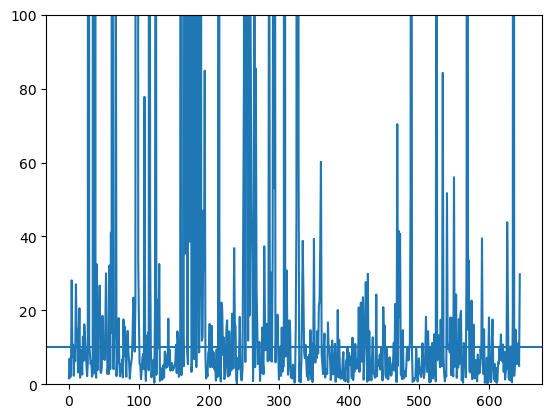

In [54]:
plt.plot(np.arange(len(TOI_df['Period (days)'][TOI_df['Period (days)'] > 0])), TOI_df['Period (days)'][TOI_df['Period (days)'] > 0])
plt.axhline(10)
plt.ylim(0,100)
plt.show()

In [24]:
for day in range(90):
   print((day % 7 == 0 or (day + 2) % 7 == 0 or (day + 5) % 7 == 0) or (day + 3) % 7 == 0)

True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True
False
True
False
True
False
True
True


In [19]:
for i in range(90):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
